**Detailed statement:**

•	Fine-tune the Mistral-7B LLM on a subset of the AG News dataset.

•	Train the model to classify news articles into four categories: World, Sports, Business, and Sci/Tech.

•	Apply LoRA (Low-Rank Adaptation) with 4-bit quantization to enable efficient training on a Google Colab T4 GPU.

•	Evaluate model performance using Training/Validation Loss during training and Accuracy/F1 Score after training.

In [ ]:
# Step 0: Initial Setup and Authentication
import torch
from huggingface_hub import notebook_login

# Log in to Hugging Face (this will prompt for your token)
notebook_login()

# Step 1: Install Required Libraries
# Using -q for a quieter installation
!pip install -q transformers datasets peft accelerate bitsandbytes matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 17.6 MB/s eta 0:00:00


In [ ]:
# Step 2: Load AG News Dataset
from datasets import load_dataset
dataset = load_dataset("ag_news")

# Step 3: Map Labels to Categories
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Step 4: Format Prompts for Instruction Tuning
def format_prompt(example):
    return {
        "text": f"""### Instruction:
Classify the following news snippet into one of the categories: World, Sports, Business, Sci/Tech.
### Input:
{example['text']}
### Response:
{label_map[example['label']]}"""
    }
dataset = dataset.map(format_prompt)

# Step 5: Split and Sample Dataset
# We split the original training data into a new training set and a validation set.
dataset_split = dataset['train'].train_test_split(test_size=0.2, seed=42)
train_val_split = dataset_split['train'].train_test_split(test_size=0.2, seed=42)

# Sample 10% of the training data to reduce training time
train_dataset = train_val_split['train'].shuffle(seed=42).select(range(int(len(train_val_split['train']) * 0.1)))
val_dataset = train_val_split['test']
test_dataset = dataset_split['test']

val_dataset  = val_dataset.shuffle(seed=42).select(range(min(1500, len(val_dataset))))
test_dataset = test_dataset.shuffle(seed=42).select(range(min(2000, len(test_dataset))))

print(f"Training Data Sample Size: {len(train_dataset)}")
print(f"Validation Data Size: {len(val_dataset)}")
print(f"Test Data Size: {len(test_dataset)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Training Data Sample Size: 7680
Validation Data Size: 1500
Test Data Size: 2000


In [ ]:
# Step 6: Load Mistral Model and Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model_name = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# Step 7: Define BitsAndBytesConfig for 4-bit Quantization
# This is the recommended way to load a model in 4-bit.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Step 7.1: Load Model with Quantization Config
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)

# Step 8: Apply LoRA (Low-Rank Adaptation)
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
# Step 9: Tokenize Prompts (without pre-padding)
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

def tokenize_function(example):
    # Padding is handled dynamically by the DataCollator, so we don't set it here.
    return tokenizer(example["text"], truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Step 10: Define Training Arguments with Memory Optimizations
training_args = TrainingArguments(
    output_dir="./mistral_topic_routing",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=2,  # Reduced batch size to fit in memory
    per_device_eval_batch_size=2,   # Reduced batch size for evaluation
    gradient_accumulation_steps=4,  # Compensate for the smaller batch size
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disables reporting to services like W&B
)

# Step 11: Train the Model
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)
trainer.train()

Map:   0%|          | 0/7680 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/tmp/ipython-input-2480342117.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,1.216600,1.175600
2,1.133200,1.164243


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/

TrainOutput(global_step=1920, training_loss=1.1748823801676431, metrics={'train_runtime': 8505.6135, 'train_samples_per_second': 1.806, 'train_steps_per_second': 0.226, 'total_flos': 7.408399724853658e+16, 'train_loss': 1.1748823801676431, 'epoch': 2.0})

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Model Evaluation ---
Accuracy: 0.9400
F1 Score: 0.9406


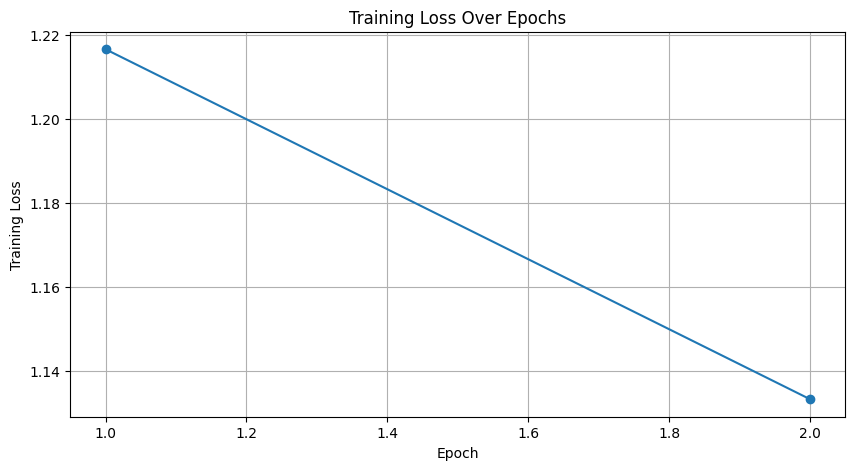


--- Zero-Shot Prediction Examples (for comparison) ---
Text: Pacers #39; O #39;Neal might head to injured list The Indian... | Predicted: Sports | True: Sports
Text: Update 2: Telstra Announces Departure of CEO Australia #39;s... | Predicted: Business | True: Business
Text: PRESIDENT PLEASED WITH COURT RULING ON ELECTION: AIDE Taipei... | Predicted: World | True: World
Text: Sharpe Comments Cause Stir in Denver (AP) AP - Never one to ... | Predicted: Sports | True: Sports
Text: Japanese races to free hostage; hopes fading Japan raced aga... | Predicted: World | True: World
Text: Linux clusters gear up for simulated combat Linux Network sc... | Predicted: Sci/Tech | True: Sci/Tech
Text: Gates gets spammed 4 million times a day So you think you ge... | Predicted: Sci/Tech | True: Sci/Tech
Text: Weapon is stadium-sized microscope A Calgary doctor aiming t... | Predicted: Sci/Tech | True: Sci/Tech
Text: Celtic back on top Glasgow, Scotland (Sports Network) - Celt... | Predicted: Sports | 

In [ ]:
# Step 12: Evaluate the Model
import random
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# ✅ Helper to normalize labels to the four canonical classes
LABELS = ["World", "Sports", "Business", "Sci/Tech"]
def normalize_label(text: str) -> str:
    t = text.strip()
    if "### Response:" in t:
        t = t.split("### Response:")[-1].strip()
    lt = t.lower()
    for lab in LABELS:
        if lt == lab.lower():
            return lab
    if "world" in lt: return "World"
    if "sport" in lt: return "Sports"
    if "business" in lt or "biz" in lt: return "Business"
    if "sci" in lt or "tech" in lt or "science" in lt: return "Sci/Tech"
    return t

def predict_labels(dataset):
    predictions = []
    references = []
    for example in dataset:
        # rebuild prompt
        prompt = example["text"].split("### Response:")[0] + "### Response:"
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        # deterministic short generation
        outputs = model.generate(**inputs, max_new_tokens=6, do_sample=False, temperature=0.0)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predicted_label = normalize_label(response)
        predictions.append(predicted_label)
        references.append(normalize_label(label_map[example["label"]]))
    return predictions, references

# Use a small random sample for quick evaluation
sample_test_data = random.sample(list(test_dataset), 50)
preds, refs = predict_labels(sample_test_data)

# Calculate and print metrics
accuracy = accuracy_score(refs, preds)
f1 = f1_score(refs, preds, average='weighted', zero_division=0)
print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


# Step 13: Visualize Training Loss
training_history = trainer.state.log_history
losses = [entry["loss"] for entry in training_history if "loss" in entry]
epochs = list(range(1, len(losses) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()


# Step 14: Zero-Shot Baseline Comparison (for context)
def zero_shot_predict(text_input):
    prompt = f"""### Instruction:
Classify the following news snippet into one of the categories: World, Sports, Business, Sci/Tech.
### Input:
{text_input}
### Response:"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=6, do_sample=False, temperature=0.0)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return normalize_label(response)

print("\n--- Zero-Shot Prediction Examples (for comparison) ---")
for sample in sample_test_data[:10]:
    original_text = sample["text"].split("### Input:\n")[1].split("\n### Response:")[0]
    pred = zero_shot_predict(original_text)
    true = label_map[sample["label"]]
    print(f"Text: {original_text[:60]}... | Predicted: {pred} | True: {true}")